<a href="https://colab.research.google.com/github/Plumz17/PCD_Assignment02/blob/main/PCD_Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Second Digital Image Processing Assignment
##Analysis of Image Enhancement Methods - Anders Emmanuel Tan (24/541351/PA/22964)

## 1. Setting Up Image to be Processed

In [185]:
#Cloning Github Repository to get the Image
!rm -rf PCD_Assignment02
!git clone https://github.com/Plumz17/PCD_Assignment02

Cloning into 'PCD_Assignment02'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 58 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 1.57 MiB | 6.74 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [187]:
# Import Important Libraries
import cv2 # For Reading Image
import numpy as np # For Manipulating Image Matrix
import matplotlib.pyplot as plt # For Showing Image
import math # For Math

filename_dark = "/content/PCD_Assignment02/dark.jpg"
filename_bright = "/content/PCD_Assignment02/bright.jpg"
filename_low = "/content/PCD_Assignment02/low.png"
filename_blur = "/content/PCD_Assignment02/blur.jpg"
filename_noisy = "/content/PCD_Assignment02/noisy.png"


img_dark = cv2.imread(filename_dark) # Read Image
img_dark = cv2.cvtColor(img_dark, cv2.COLOR_BGR2GRAY) # Change the color map
img_low = cv2.imread(filename_low)
img_low = cv2.cvtColor(img_low, cv2.COLOR_BGR2GRAY)
img_blur = cv2.imread(filename_blur)
img_blur = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
img_noisy = cv2.imread(filename_noisy)
img_noisy = cv2.cvtColor(img_noisy, cv2.COLOR_BGR2GRAY)

In [199]:
def show(before, after, title1="Before", title2="After"): # Helper function to check the before and after of the enhancement
  plt.figure(figsize=(10,5))

   # Show original
  plt.subplot(1,2,1)
  plt.imshow(before, cmap='gray')
  plt.title(title1)
  plt.axis("off")

  # Show processed
  plt.subplot(1,2,2)
  plt.imshow(after, cmap='gray')
  plt.title(title2)
  plt.axis("off")

  plt.show()

## 2. Enhancing Dark/Bright Images

### 2A. Negative Image

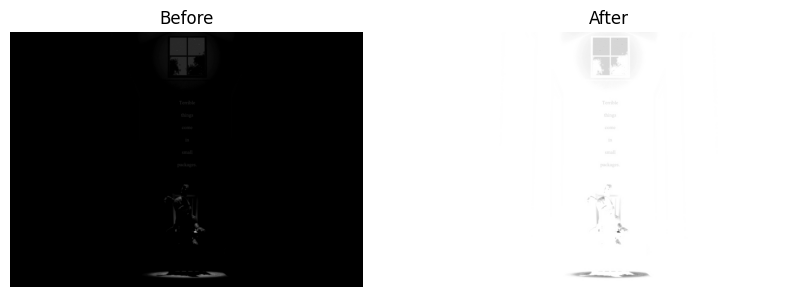

In [200]:
def negative(img):
  out = img.copy()
  L = 256 # max pixel
  for i in range(out.shape[0]): #Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(out.shape[1]): #Iterate for every pixel in the y axis
      out[i][j] = L - 1 - out[i][j] # Use the formula s = (L - 1) - r, where L is 256 so s = 255 - r
  return out

show(img_dark, negative(img_dark))

### 2B. Logarithmic Transformation

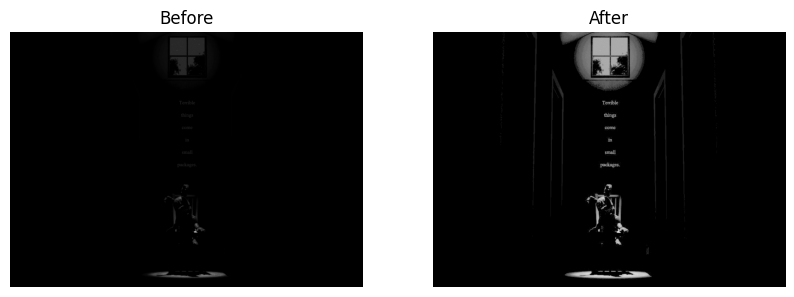

In [202]:
def log(img):
  out = img.copy().astype(float) # So we can handle commas to be log-ed
  R_max = np.max(out)
  L = 256
  c = (L - 1) / np.log(1 + R_max) # Normilize the C to fit (0, 255)
  for i in range(out.shape[0]):#Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(out.shape[1]): #Iterate for every pixel in the y axis
      out[i][j] = c * np.log(1 + out[i][j]) #Use the formula s = c * log(1+r)
  return out.astype(np.uint8)

show(img_dark, log(img_dark))

### 2C. Gamma Correction

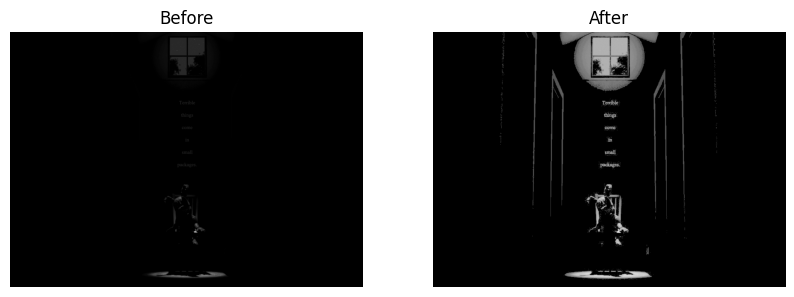

In [201]:
def gamma(img, gamma=0.2):
  out = img.astype(float)
  R_max = np.max(img)
  L = 256
  c = (L - 1) / (R_max ** gamma) # Normilize the C to fit (0, 255)
  for i in range(out.shape[0]):#Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(out.shape[1]): #Iterate for every pixel in the y axis
      out[i][j] = c * (img[i][j] ** gamma) # Use the Formula s = c * r ^ gamma
  return out.astype(np.uint8)

show(img_dark, gamma(img_dark))

## 3. Enhancing Low Contrast Images

###3A. Contrast Stretching


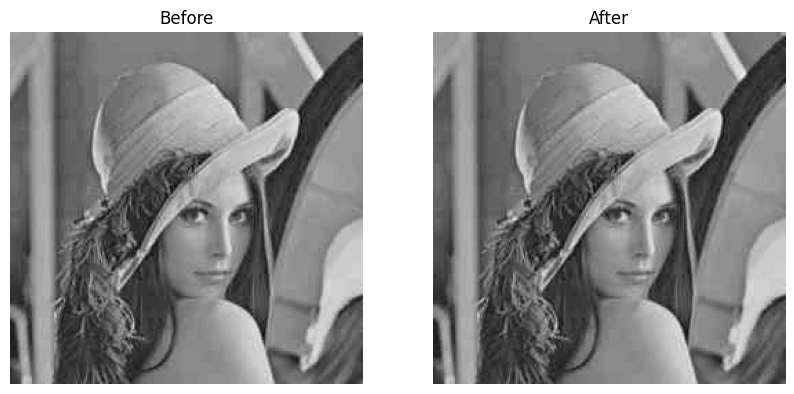

In [203]:
def stretch(img):
  out = img.astype(float)
  # Grab some variables for the formula
  max, min = np.max(out), np.min(out)
  a, b = 0, 255
  for i in range(out.shape[0]):#Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(out.shape[1]): #Iterate for every pixel in the y axis
      out[i][j] = (b - a) * (out[i][j] - min) / (max - min) + a # Apply constrast stretching formula
  return out.astype(np.uint8)

show(img_low, stretch(img_low))

### 3B. Histogram Equalization

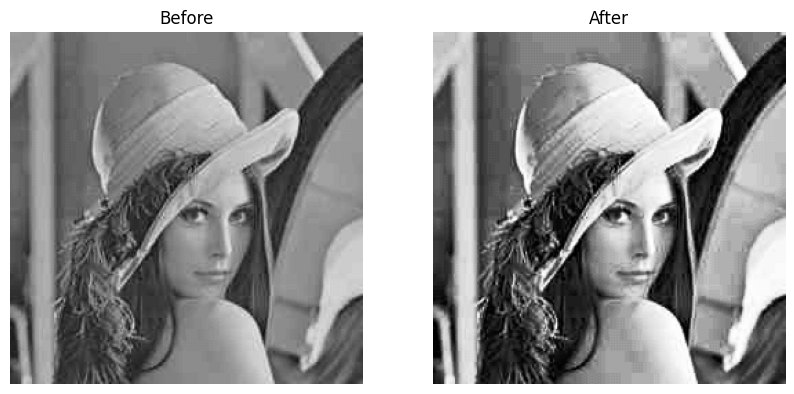

In [204]:
def hist(img):
  L = 256
  #Make Histograms
  hist = np.zeros(L)
  for i in range(img.shape[0]):#Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(img.shape[1]): #Iterate for every pixel in the y axis
      hist[int(img[i,j])] += 1 # Add that pixel to the histogram

  pdf = hist / (img.shape[0] * img.shape[1]) # Calculate the probablity distribution function (From Probability and Stotastic Process Subject)
  cdf = np.zeros(L)
  cdf[0] = pdf[0]
  for i in range(1, L): # Calculate the cumulative distribution function
    cdf[i] = cdf[i - 1] + pdf[i]

  cdf = (cdf * (L - 1)).astype(np.uint8) # Calculate the pixel value using cdf so it's between 0 and 255

  out = np.zeros(img.shape, dtype=np.uint8)
  for i in range(out.shape[0]):#Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(out.shape[1]): #Iterate for every pixel in the y axis
      out[i,j] = cdf[img[i,j]]
  return out

show(img_low, hist(img_low))

### 3C. Grey-Level Slicing

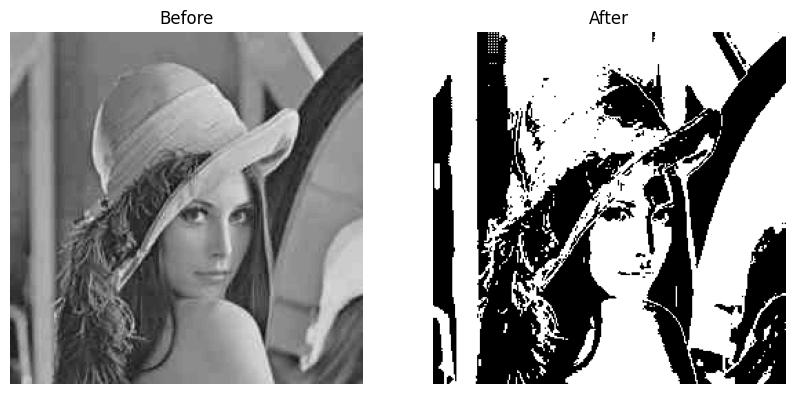

In [205]:
def grey(img, low, high):
  out = img.copy().astype(float)
  for i in range(out.shape[0]): #Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(out.shape[1]): #Iterate for every pixel in the y axis
      if (low <= img[i, j] <= high):
        out[i, j] = 255
      else:
        out[i, j] = 0
  return out.astype(np.uint8)

show(img_low, grey(img_low, 130, 170))


## 4. Enhancing Noisy Images

### 4A. Average Smoothing Filter

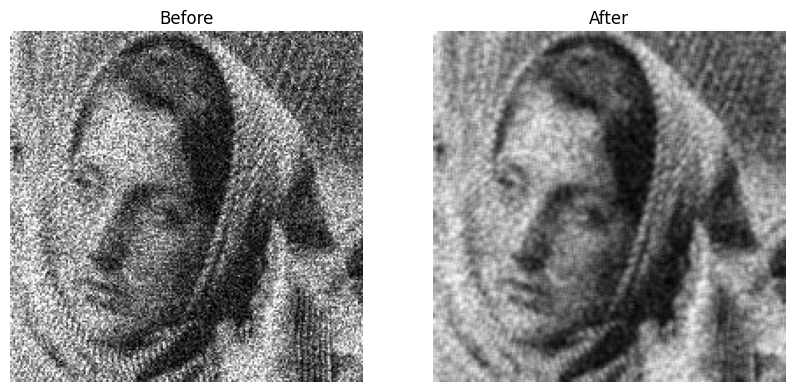

In [206]:
def smooth(img):
  kernel = np.array([[0.11, 0.11, 0.11],
                     [0.11, 0.11, 0.11],
                     [0.11, 0.11, 0.11]])
  blurred = cv2.filter2D(img, -1, kernel) # Blur Image

  return np.clip(blurred, 0, 255).astype(np.uint8)
show(img_noisy, smooth(img_noisy))


### 4B. Gaussian Filter

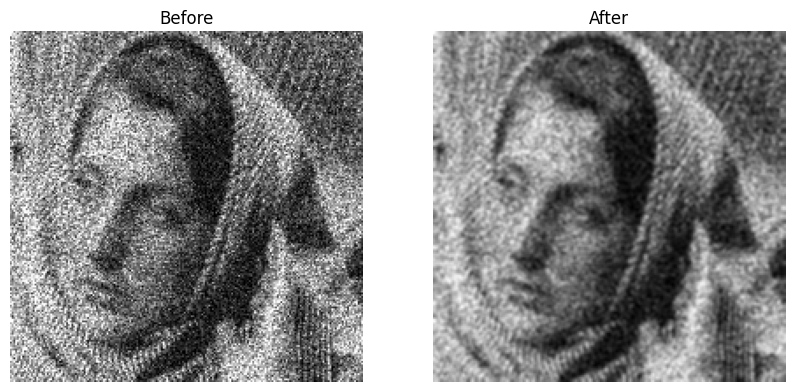

In [207]:
def gaussian_kernel(size=3, sigma=1):
  k = size // 2
  kernel = np.zeros((size,size), dtype = np.float32)
  for x in range(-k, k+1):
    for y in range(-k, k+1):
      kernel[x+k, y+k] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
  kernel /= (2 * np.pi * sigma ** 2)
  return kernel / np.sum(kernel)

def gauss(img):
  kernel = gaussian_kernel()
  blurred = cv2.filter2D(img, -1, kernel) # Blur Image

  return np.clip(blurred, 0, 255).astype(np.uint8)
show(img_noisy, gauss(img_noisy))


## 5. Enhancing Blurred Images

### 5A. Unsharp Filter

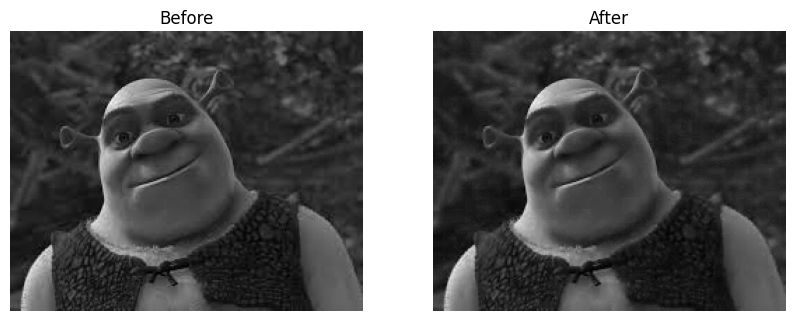

In [208]:
def avg(img):
  kernel = np.array([[0.11, 0.11, 0.11],
                     [0.11, 0.11, 0.11],
                     [0.11, 0.11, 0.11]])
  blurred = cv2.filter2D(img, -1, kernel) # Blur Image
  sharpened = img+0.03*(img-blurred) # Sharpen Image by using the blurred image

  return np.clip(sharpened, 0, 255).astype(np.uint8)
show(img_blur, avg(img_blur))


### 5B. Laplasian Filter

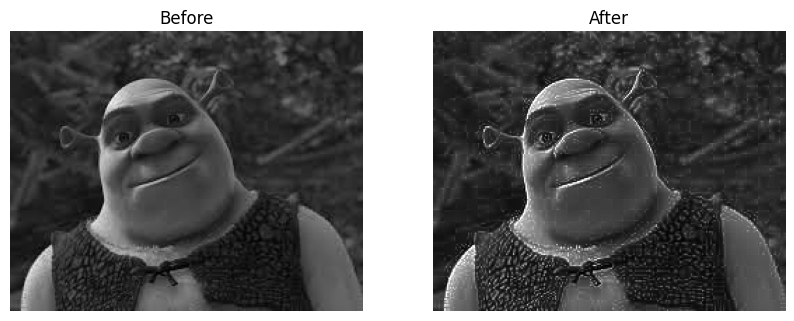

In [209]:
def lap(img):
  lap_kernel = np.array([[0, -1, 0],
                     [-1, 4, -1],
                     [0, -1, 0]], dtype=np.float32)
  lap = cv2.filter2D(img, -1, lap_kernel) # Blur Image
  sharpened = img.astype(np.float32) + lap # Sharpen Image by using the blurred image

  return np.clip(sharpened, 0, 255).astype(np.uint8)
show(img_blur, lap(img_blur))
